In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    E = 0
    E_y = 0
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(y_value)
    plt.grid(True)
    plt.plot(x_value, y_value, "o")
    k, b = mnk_non_zero(x_value, y_value)
    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)

    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    E = 0
    E_y = 0
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(x_value)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)

    print("k, b =", k, b)
    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



<>:234: SyntaxWarning: invalid escape sequence '\p'
<>:237: SyntaxWarning: invalid escape sequence '\p'
<>:239: SyntaxWarning: invalid escape sequence '\p'
<>:239: SyntaxWarning: invalid escape sequence '\c'
<>:242: SyntaxWarning: invalid escape sequence '\p'
<>:234: SyntaxWarning: invalid escape sequence '\p'
<>:237: SyntaxWarning: invalid escape sequence '\p'
<>:239: SyntaxWarning: invalid escape sequence '\p'
<>:239: SyntaxWarning: invalid escape sequence '\c'
<>:242: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_4120\2410850710.py:234: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_4120\2410850710.py:237: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_4120\2410850710.py:239: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10^{E

# Нахождение динамической постоянной
Данные ниже, делитель 1/2000 

In [12]:
U = DData(69, epsilon=1/150) / 150 * 3
R2 = DData(10000, 100)
R1 = R2/2000
R0 = DData(560, 10)
L = DData(1.94, 0.02)

p1 = pd.DataFrame()
p1["R, кОм"] = [5,6,7,10,15,20,25,30,40,50]
p1["x, мм"] = [238,202,176,125,86,65,53,44,33,27]
p1["R, кОм"] = p1["R, кОм"].apply(lambda x: DData(x,epsilon=0.001, E=3))
p1["x, мм"] = p1["x, мм"].apply(lambda x: DData(x, 2, E=-3))


p1["I, нА"] = U*(R1/R2)/(p1["R, кОм"] + R0)
DData.changeEInSerias(p1["I, нА"], -9)
p1

,"R, кОм","x, мм","I, нА"
0,$5.0000 \pm 0.0050$,$238.0 \pm 2.0$,$124.1 \pm 2.0$
1,$6.0000 \pm 0.0060$,$202.0 \pm 2.0$,$105.2 \pm 1.7$
2,$7.0000 \pm 0.0070$,$176.0 \pm 2.0$,$91.3 \pm 1.4$
3,$10.000 \pm 0.010$,$125.0 \pm 2.0$,$65.3 \pm 1.0$
4,$15.000 \pm 0.015$,$86.0 \pm 2.0$,$44.34 \pm 0.70$
5,$20.000 \pm 0.020$,$65.0 \pm 2.0$,$33.56 \pm 0.53$
6,$25.000 \pm 0.025$,$53.0 \pm 2.0$,$27.00 \pm 0.42$
7,$30.000 \pm 0.030$,$44.0 \pm 2.0$,$22.58 \pm 0.35$
8,$40.000 \pm 0.040$,$33.0 \pm 2.0$,$17.01 \pm 0.27$
9,$50.000 \pm 0.050$,$27.0 \pm 2.0$,$13.65 \pm 0.21$


[  5.9 259.1]
k, b = $0.5229 \pm 0.0010$ $-0.45 \pm 0.13$
$2.029 \pm 0.021$ $0.4928 \pm 0.0052$


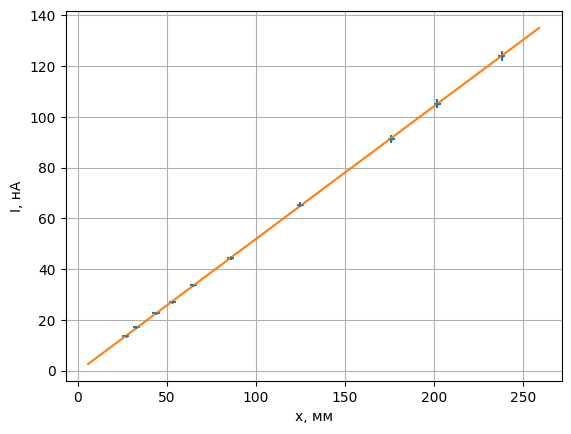

In [42]:
plt.xlabel("x, мм")
plt.ylabel("I, нА")
Ix, _ = linearcalc_error(p1["x, мм"], p1["I, нА"])
Ci = Ix * 2 * L
Ci.E = -6
print(Ci, 1/Ci)
plt.savefig("IX.png",dpi=300)

$C_i$ = $2.029 \pm 0.021 \cdot 10^{-6} \cdot \frac{А}{мм/м}$ 
$S_i$ = $0.4928 \pm 0.0052 \cdot 10^{6} \cdot \frac{мм/м}{А}$ 

# Декремент затухания

In [14]:
x1 = DData(213, 1, E = -3)
x2 = DData(164, 1, E=-3)
x3 = DData(125, 1, E=-3)
T0 = DData(28.97, 0.4)/6
theta = DData(np.log((x1/x2).value), x1.epsilon + x2.epsilon)
theta_ = DData(np.log((x2/x3).value), x2.epsilon + x3.epsilon)
print(theta, theta_)


$0.261 \pm 0.011$ $0.272 \pm 0.014$


In [25]:
table2 = pd.DataFrame()
table2["R, кОм"] = [24,30,35,40,45,55,65,80]
table2["x1, мм"] = [182,147,205,180,160,195,167,178]
table2["x2, мм"] = [62, 61, 76, 91, 87, 116,105,78]
table2["n"]      = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,1]
table2["R, кОм"] = table2["R, кОм"].apply(lambda x: DData(x, epsilon=0.001, E=3))
table2["$\\thetta$"] = (np.log(table2["x1, мм"]/table2["x2, мм"])/table2["n"]).apply(lambda x: DData(x, 2/180+2/90))
table2["$R_{кр}$, Ом"] = (table2["R, кОм"] + R0)*((2*3.14/table2["$\\thetta$"])**2+1)**-0.5 - R0

table2["R_sum"] = table2["R, кОм"] + R0
DData.changeEInSerias(table2["R_sum"],3)

R_cr_1 = SerDData(table2["$R_{кр}$, Ом"]).mean
print(R_cr_1)
table2

$8610.0 \pm 280.0$


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_4120\2410850710.py:241: UserWarning: Что-то сломалось при отображении 
  warnings.warn("Что-то сломалось при отображении ")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_4120\2410850710.py:241: UserWarning: Что-то сломалось при отображении 
  warnings.warn("Что-то сломалось при отображении ")


,"R, кОм","x1, мм","x2, мм",n,$\thetta$,"$R_{кр}$, Ом",R_sum
0,$24.000 \pm 0.024$,182,62,0.5,$2.154 \pm 0.033$,$7410.0 \pm 110.0$,$24.560 \pm 0.026$
1,$30.000 \pm 0.030$,147,61,0.5,$1.759 \pm 0.033$,$7680.0 \pm 150.0$,$30.560 \pm 0.032$
2,$35.000 \pm 0.035$,205,76,0.5,$1.985 \pm 0.033$,$10160.0 \pm 160.0$,$35.560 \pm 0.036$
3,$40.000 \pm 0.040$,180,91,0.5,$1.364 \pm 0.033$,$8050.0 \pm 200.0$,$40.560 \pm 0.041$
4,$45.000 \pm 0.045$,160,87,0.5,$1.219 \pm 0.033$,$8120.0 \pm 230.0$,$45.560 \pm 0.046$
5,$55.000 \pm 0.055$,195,116,0.5,$1.039 \pm 0.033$,$8510.0 \pm 280.0$,$55.560 \pm 0.056$
6,$65.000 \pm 0.065$,167,105,0.5,$0.928 \pm 0.033$,$9020.0 \pm 340.0$,$65.560 \pm 0.066$
7,$80.000 \pm 0.080$,178,78,1.0,$0.825 \pm 0.033$,$9930.0 \pm 420.0$,$80.560 \pm 0.081$


[  14.5216 7078.5856]
k, b = $0.000223 \pm 0.000020$ $0.126 \pm 0.062$
$10100.0 \pm 470.0$


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_4120\2410850710.py:241: UserWarning: Что-то сломалось при отображении 
  warnings.warn("Что-то сломалось при отображении ")


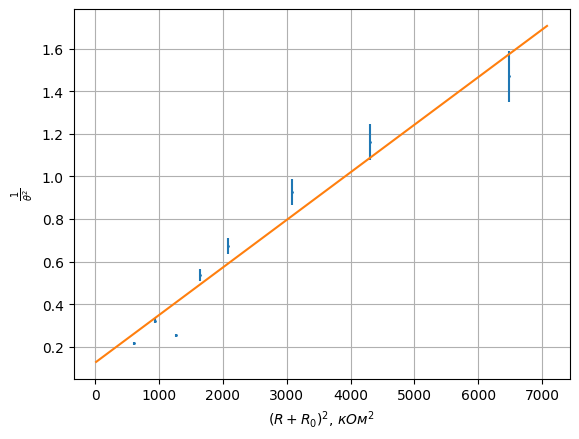

In [40]:
plt.xlabel("$(R+R_0)^2$, $кОм^2$")
plt.ylabel("$\\frac{1}{\\theta^2}$")
k, _ = linearcalc_error((table2["R_sum"])**2,table2["$\\thetta$"]**-2)
k.E = 0
R_cr_3 = 1/2/3.14/k**0.5-R0
R_cr_3.E = 0
print(R_cr_3)
plt.savefig("theta.png", dpi = 300)

$R_{кр} = 8610.0 \pm 280.0 Ом$\
$R_{кр} = 10100.0 \pm 470.0$ Ом

# Баллистический метод


[-0.02808879  0.30898866]
k, b = $-576 \pm 40$ $205.5 \pm 4.9$
$0.203 \pm 0.018$ $4.37 \pm 0.43$ $88.6 \pm 3.9$ $2.42 \pm 0.11$ $1.120 \pm 0.021$


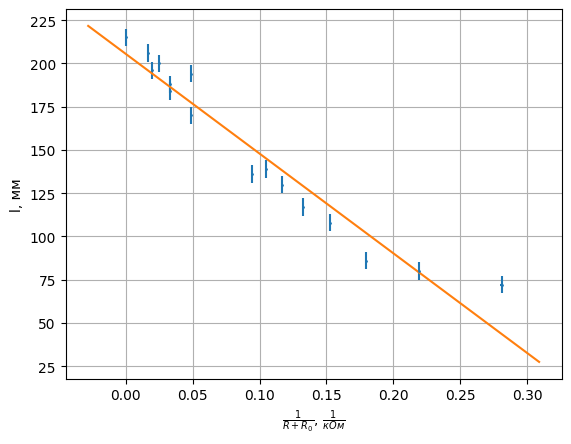

In [48]:
C = DData(2, 0.01, E=-6)
L_svob = DData(225, 10, E=-3)

table3 = pd.DataFrame()
table3["R, кОм"] = [1000000,60,50,30,20,10,5,4,3,6,7,8,9,20,30,40]
table3["x, мм"] =  [215,206,196,188,170,136,86,80,72,108,117,130,139,194,184,200]
table3["R, кОм"] = table3["R, кОм"].apply(lambda x: DData(x, 0.01, E=3))
table3["x, мм"] = table3["x, мм"].apply(lambda x: DData(x, 5, E=-3))
R0.E=3
plt.xlabel("$\\frac{1}{R+R_0}$, $\\frac{1}{кОм}$")
plt.ylabel("l, мм")

table3_srez = table3[table3["R, кОм"]>6000]

k, b = linearcalc_error(1/(table3["R, кОм"]+R0), table3["x, мм"])
l_cr = L_svob*2.7182**(theta.value/4)/2.71
x_cr = (l_cr - b)/k
R_cr_2 = 1/x_cr - R0
C_q_cr = 1/50*U*2*L*C/l_cr
C_q_cr.E = -6
tao = R0*C
tao.E=-3
print(x_cr, R_cr_2, l_cr, DData(C_q_cr), tao)
plt.savefig("LR.png", dpi=300)


# Выводы
## Для режима измерения тока 
$C_i$ = $2.029 \pm 0.021 \cdot 10^{-6} \cdot \frac{А}{мм/м}$ \
$S_i$ = $0.4928 \pm 0.0052 \cdot 10^{6} \cdot \frac{мм/м}{А}$ \
$R_{кр} = 10100.0 \pm 470.0$ Ом
## Для балистического режима\
$R_{кр}$ = $4.37 \pm 0.43$ кОм\
$C_q^{кр}$ =  $2.42 \pm 0.11 \frac{Кл}{мм/м}$\
$\tau = 1.1 мс$, что много меньше периода колебаний T = 5с\
##  Экспериментально 
$R_{кр} \approx 8.1 кОм$

In [18]:
p1.to_clipboard()

In [19]:
table2.to_clipboard()

C:\Users\RedBrean\AppData\Local\Temp\ipykernel_4120\2410850710.py:241: UserWarning: Что-то сломалось при отображении 
  warnings.warn("Что-то сломалось при отображении ")


In [20]:
table3.to_clipboard()

In [21]:
R0.E=0
print(U, R0, Ci, l_cr, R_cr_2, C_q_cr)

$1.3800 \pm 0.0092$ $560 \pm 10$ $0.002029 \pm 0.000021$ $88.6 \pm 3.9$ $4.37 \pm 0.43$ $2.42 \pm 0.11$
